In [1]:
## ALL IMPORTS FOR A NEW NOTEBOOK
__SEED = 0
__N_FOLDS = 3
__NROWS = None

import os, sys, random, math
import matplotlib.pyplot as plt
# %matplotlib inline
plt.style.use('ggplot')

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import impute

import ml_utils as mutils
import time

font = {'size'   : 13}
matplotlib.rc('font', **font)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mutils.seed_everything(__SEED)

fold1 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED)
fold2 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED+3)
fold3 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED+5)

In [2]:
train = pd.read_csv("train.csv", index_col="id")
train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,b574c9841,708248125,5ddc9a726,745b909d1,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,673bdf1f6,23edb8da3,3a33ef960,bdaa56dd1,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,777d1ac2c,3a7975e46,bc9cc2a94,NaN,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [3]:
test = pd.read_csv("test.csv", index_col="id")
test.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,,,
600000,0.0,0.0,0.0,F,Y,Blue,Polygon,Axolotl,Finland,Piano,52f6dd16c,147d704e4,8d857a0a1,ca9ad1d4b,fced9e114,3.0,Novice,Boiling Hot,f,U,oU,3.0,9.0
600001,0.0,0.0,0.0,F,Y,Red,Circle,Lion,Russia,Bassoon,691ebeae8,8653dcc2e,67a8d4ebb,060a21580,7ca8775da,1.0,Novice,Cold,n,N,NaN,2.0,8.0
600002,0.0,0.0,0.0,F,Y,Blue,Circle,Axolotl,Russia,Theremin,81f792c16,6cdda499e,69403e18c,165e81a00,5940334c9,1.0,Expert,Warm,i,N,DN,2.0,6.0
600003,1.0,0.0,0.0,F,N,Red,Polygon,Axolotl,Costa Rica,Bassoon,c9134205b,acbca4827,cb681246b,77d41330d,6fbdeefc8,1.0,Expert,Hot,m,B,AG,1.0,6.0
600004,0.0,0.0,1.0,F,Y,Red,Circle,NaN,Finland,Theremin,f0f100f57,6f800b9af,cd9feb5c6,2218d9dfe,2a27c8fde,1.0,Contributor,Lava Hot,o,J,DT,3.0,3.0


In [4]:
mutils.summarize_all(train)

Dataset Shape: (600000, 24)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,bin_0,float64,17894,2,0,1,0,0.44
1,bin_1,float64,18003,2,0,1,1,0.69
2,bin_2,float64,17930,2,0,0,0,0.85
3,bin_3,object,18014,2,F,F,F,0.95
4,bin_4,object,18047,2,N,Y,N,1.00
5,nom_0,object,18252,3,Red,Red,Red,1.31
6,nom_1,object,18156,6,Trapezoid,Star,NaN,2.27
7,nom_2,object,18035,6,Hamster,Axolotl,Hamster,2.27
8,nom_3,object,18121,6,Russia,NaN,Canada,2.27
9,nom_4,object,18035,4,Bassoon,Theremin,Bassoon,1.52


In [5]:
stats, train_only, test_only = mutils.summarize_categorical(train, test, exclude_feat=["target"], target_for_cramerV="target")

In [6]:
stats

,Feature,Target Cramer's V,Unique values (Train),Unique values (Test),Train only value counts,Test only value counts,Missing (Train),Missing (Test),Value with the highest counts (Train),DataType
0,bin_0,0.060,2,2,0(0.0),0(0.0),17894(2.982),17894(2.982),0.0(88.063),float64
1,bin_1,0.018,2,2,0(0.0),0(0.0),18003(3.0),18003(3.0),0.0(79.003),float64
2,bin_2,0.066,2,2,0(0.0),0(0.0),17930(2.988),17930(2.988),0.0(69.974),float64
3,bin_3,0.001,2,2,0(0.0),0(0.0),18014(3.002),18014(3.002),F(61.035),object
4,bin_4,0.019,2,2,0(0.0),0(0.0),18047(3.008),18047(3.008),N(52.057),object
5,nom_0,0.016,3,3,0(0.0),0(0.0),18252(3.042),18252(3.042),Red(53.881),object
6,nom_1,0.071,6,6,0(0.0),0(0.0),18156(3.026),18156(3.026),Triangle(27.365),object
7,nom_2,0.046,6,6,0(0.0),0(0.0),18035(3.006),18035(3.006),Hamster(27.483),object
8,nom_3,0.060,6,6,0(0.0),0(0.0),18121(3.02),18121(3.02),India(27.478),object
9,nom_4,0.042,4,4,0(0.0),0(0.0),18035(3.006),18035(3.006),Theremin(51.437),object


<Figure size 432x288 with 0 Axes>

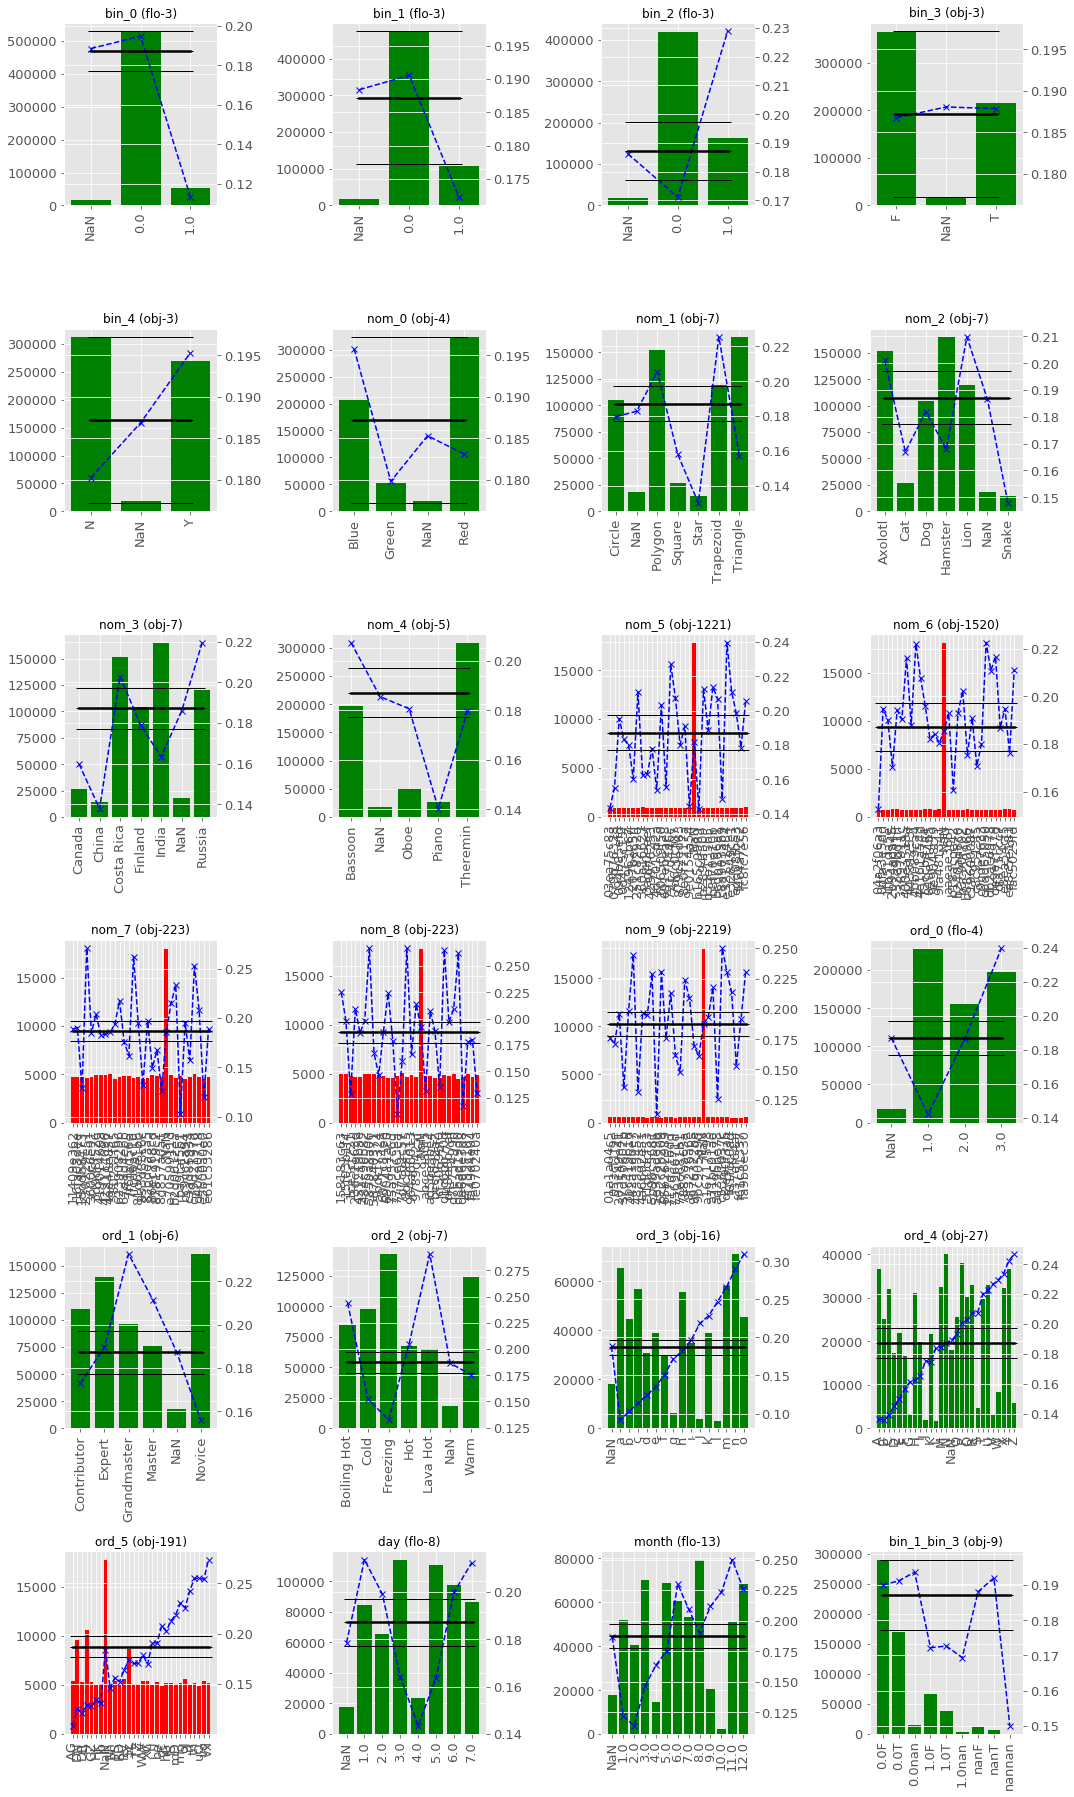

In [34]:
mutils.plot_multiple_categorical(train, [f for f in train.columns if f not in ["target"]], top_n=30, col_target="target")

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

lr_params = {
#     "solver":"lbfgs",
    "solver":"lbfgs",
    "penalty":"l2",
    "max_iter":2222,
    "verbose":1,
    "n_jobs":5,
#     "l1_ratio":0.05,
    "random_state":__SEED,
    "C":0.123456789
}

In [9]:
def cross_val_print(pipe, X, y, cv, scoring="roc_auc", best_score=0.):
    scores = ms.cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=True)
    cv_score = scores["test_score"].mean()
    train_score = scores["train_score"].mean()
    
    if cv == fold1:
        precision=1
    elif cv == fold2:
        precision=2
    elif cv == fold3:
        precision=3
        
    down = '\u2193'
    up = "\u2191"
    curarr = "\u30000"
    if (cv_score-best_score)>0:
        curarr = up
    elif (cv_score-best_score)<0:
        curarr = down
    
    print("{}  CV{} score on valid: {:.7f} - Previous best valid score: {:.7f} - Train mean score: {:6f}".format(curarr, precision, cv_score, best_score, train_score))
    
    if cv_score>best_score:
        best_score = cv_score
    
    return cv_score, best_score

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
class CustomMostFrequentImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.mode = None
    def fit(self, X, y=None):
        self.mode = X[self.columns].mode().values[0]
        return self
    def transform(self, X, y=None):
        df = X.copy()
        for i, col in enumerate(self.columns):
#             print(i)
            df[col].fillna(self.mode[i],inplace=True)
        return df

In [13]:
def fit_save(model, train, target, test, label):
    preds = model.fit(train, target).predict_proba(test)[:,1]
    pd.DataFrame({"id":test.index.values, "target":preds}).to_csv(label+"_submission.csv", index=False)

### Logistic Regression, SimpleImputer with NA replaced with most frequent and one hot encoding all

In [22]:
%%time
all_train_cols = [col for col in train.columns if col not in ["target"]] 

print(all_train_cols)
imputer = CustomMostFrequentImputer(all_train_cols)
ohe = (pp.OneHotEncoder(categories="auto",dtype="uint8",handle_unknown="ignore"), all_train_cols)

pipe = make_pipeline(imputer, make_column_transformer(ohe), LogisticRegression(**lr_params))

_, b1 = cross_val_print(pipe, train.drop(["target"], axis=1), train["target"], cv=fold1)
_, b2 = cross_val_print(pipe, train.drop(["target"], axis=1), train["target"], cv=fold2)
_, b3 = cross_val_print(pipe, train.drop(["target"], axis=1), train["target"], cv=fold3)

print("Average: {}".format((b1+b2+b3)/3.0))

['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month']


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   28.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   29.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   26.2s finished


↑  CV1 score on valid: 0.7833945 - Previous best valid score: 0.0000000 - Train mean score: 0.799158


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   27.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   31.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   29.4s finished


↑  CV2 score on valid: 0.7834381 - Previous best valid score: 0.0000000 - Train mean score: 0.799247


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   29.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   28.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   30.5s finished


↑  CV3 score on valid: 0.7836562 - Previous best valid score: 0.0000000 - Train mean score: 0.799118
Average: 0.7834962882422755
CPU times: user 3min 8s, sys: 13.9 s, total: 3min 22s
Wall time: 5min 16s


In [21]:
pipe = make_pipeline(imputer, make_column_transformer(ohe), LogisticRegression(**lr_params))
fit_save(pipe, train.drop(["target"], axis=1), train["target"], test, "ALL_ONE_HOT")

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   49.0s finished


## Is bin_3 useful?

In [30]:
%%time
drop_cols = ["target", "bin_3"]
all_train_cols = [col for col in train.columns if col not in drop_cols] 

print(all_train_cols)
imputer = CustomMostFrequentImputer(all_train_cols)
ohe = (pp.OneHotEncoder(categories="auto",dtype="uint8",handle_unknown="ignore"), all_train_cols)

pipe = make_pipeline(imputer, make_column_transformer(ohe), LogisticRegression(**lr_params))

_, b1_chk = cross_val_print(pipe, train.drop(drop_cols, axis=1), train["target"], cv=fold1, best_score=b1)
_, b2_chk = cross_val_print(pipe, train.drop(drop_cols, axis=1), train["target"], cv=fold2, best_score=b2)
_, b3_chk = cross_val_print(pipe, train.drop(drop_cols, axis=1), train["target"], cv=fold3, best_score=b3)

print("Average: {}".format((b1+b2+b3)/3.0))

['bin_0', 'bin_1', 'bin_2', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month']


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   28.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   26.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   27.3s finished


↑  CV1 score on valid: 0.7833962 - Previous best valid score: 0.7833945 - Train mean score: 0.799157


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   26.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   25.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   26.5s finished


↑  CV2 score on valid: 0.7834393 - Previous best valid score: 0.7834381 - Train mean score: 0.799246


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   25.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   29.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   26.9s finished


↑  CV3 score on valid: 0.7836594 - Previous best valid score: 0.7836562 - Train mean score: 0.799116
Average: 0.7834962882422755
CPU times: user 3min 4s, sys: 13.8 s, total: 3min 18s
Wall time: 4min 53s


In [31]:
pipe = make_pipeline(imputer, make_column_transformer(ohe), LogisticRegression(**lr_params))
fit_save(pipe, train.drop(drop_cols, axis=1), train["target"], test, "DROPPED_BIN_3_ALL_ONE_HOT")

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   45.4s finished


CV said, it's useful, but submission score didn't improve

## Merge bin_3 and bin_1, one hot rest

Based on the cramer's V, bin_3 is not that good, and second least good is bin_3, so merging them may result in a good thing?....may be?

In [32]:
train["bin_1_bin_3"] = train["bin_1"].astype(str)+train["bin_3"].astype(str)

In [33]:
%%time
drop_cols = ["target", "bin_3", "bin_1"]
all_train_cols = [col for col in train.columns if col not in drop_cols] 

print(all_train_cols)
imputer = CustomMostFrequentImputer(all_train_cols)
ohe = (pp.OneHotEncoder(categories="auto",dtype="uint8",handle_unknown="ignore"), all_train_cols)

pipe = make_pipeline(imputer, make_column_transformer(ohe), LogisticRegression(**lr_params))

_, b1_chk = cross_val_print(pipe, train.drop(drop_cols, axis=1), train["target"], cv=fold1, best_score=b1)
_, b2_chk = cross_val_print(pipe, train.drop(drop_cols, axis=1), train["target"], cv=fold2, best_score=b2)
_, b3_chk = cross_val_print(pipe, train.drop(drop_cols, axis=1), train["target"], cv=fold3, best_score=b3)

print("Average: {}".format((b1+b2+b3)/3.0))

['bin_0', 'bin_2', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'bin_1_bin_3']


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   25.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   27.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   27.2s finished


↑  CV1 score on valid: 0.7833957 - Previous best valid score: 0.7833945 - Train mean score: 0.799168


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   28.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   25.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   27.0s finished


↓  CV2 score on valid: 0.7834304 - Previous best valid score: 0.7834381 - Train mean score: 0.799261


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   24.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   28.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   25.5s finished


↓  CV3 score on valid: 0.7836540 - Previous best valid score: 0.7836562 - Train mean score: 0.799126
Average: 0.7834962882422755
CPU times: user 3min 11s, sys: 14.3 s, total: 3min 26s
Wall time: 4min 53s


So far, we see that, we may drop bin_3, which improves score on all folds, but we should'nt drop bin_1 & bin_3 and add bin_1_bin_3, because it lessens score in two of the three folds.

## Time for the Ordinal variables

<Figure size 432x288 with 0 Axes>

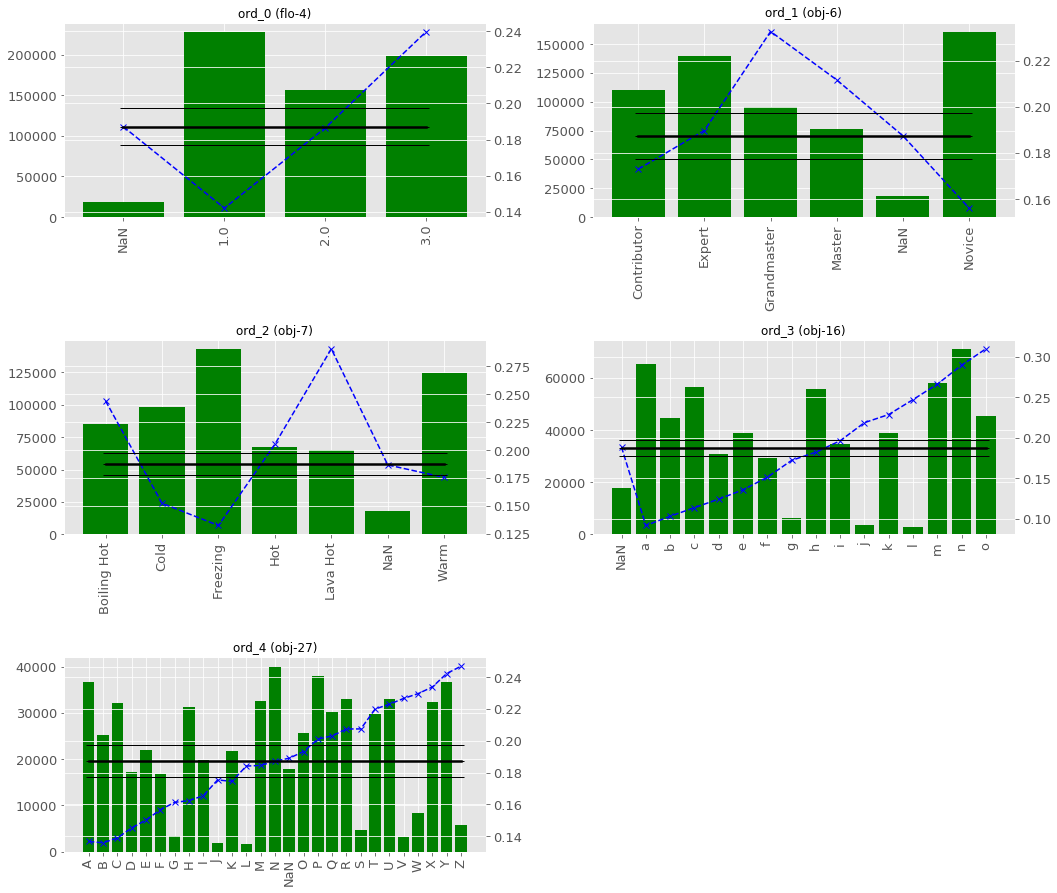

In [173]:
# plot
ordinal_features = ["ord_"+str(i) for i in range(5)]
mutils.plot_multiple_categorical(train, ordinal_features, col_target="target", top_n=100, n_subplots_per_row=2)

In [174]:
from string import ascii_lowercase, ascii_uppercase
tmp = train.copy()
tmp["ord_1"] = tmp["ord_1"].map({"Novice":0,"Contributor":1, "Expert":2, "Master":3, "Grandmaster":4})
tmp["ord_2"] = tmp["ord_2"].map({"Freezing":0,"Cold":1, "Warm":2, "Hot":3, "Boiling Hot":4,"Lava Hot":5})

tmp["ord_0"] = tmp["ord_0"].fillna(2)
tmp["ord_0"] = tmp["ord_0"]-1

tmp["ord_1"] = tmp["ord_1"].fillna(2)
tmp["ord_2"] = tmp["ord_2"].fillna(2)

tmp["ord_3"] = tmp["ord_3"].fillna("h")
tmp["ord_3"] = tmp["ord_3"].map({k:v for v,k in enumerate(ascii_lowercase)})

tmp["ord_4"] = tmp["ord_4"].fillna("K")
tmp["ord_4"] = tmp["ord_4"].map({k:v for v,k in enumerate(ascii_uppercase)})

# mask = tmp['ord_5'].isna() 
# ind = tmp['ord_5'].loc[mask].sample(frac=0.1).index
# tmp.loc[ind, 'ord_5'] = "RV"

# mask = tmp['ord_5'].isna() 
# ind = tmp['ord_5'].loc[mask].sample(frac=0.1).index
# tmp.loc[ind, 'ord_5'] = "TL"

# mask = tmp['ord_5'].isna() 
# ind = tmp['ord_5'].loc[mask].sample(frac=0.25).index
# tmp.loc[ind, 'ord_5'] = "TZ"

# mask = tmp['ord_5'].isna() 
# ind = tmp['ord_5'].loc[mask].sample(frac=0.07).index
# tmp.loc[ind, 'ord_5'] = "WW"

# mask = tmp['ord_5'].isna() 
# ind = tmp['ord_5'].loc[mask].sample(frac=0.5).index
# tmp.loc[ind, 'ord_5'] = "XC"

# mask = tmp['ord_5'].isna() 
# ind = tmp['ord_5'].loc[mask].sample(frac=0.1).index
# tmp.loc[ind, 'ord_5'] = "DR"

# mask = tmp['ord_5'].isna() 
# ind = tmp['ord_5'].loc[mask].sample(frac=0.05).index
# tmp.loc[ind, 'ord_5'] = "GZ"

# mask = tmp['ord_5'].isna() 
# ind = tmp['ord_5'].loc[mask].sample(frac=0.2).index
# tmp.loc[ind, 'ord_5'] = "Ib"
# tmp["ord_5"] = tmp["ord_5"].fillna("RD")


# tmp["ord_5"] = tmp["ord_5"].map({k:v for v,k in enumerate(np.sort(tmp["ord_5"].values))})

<Figure size 432x288 with 0 Axes>

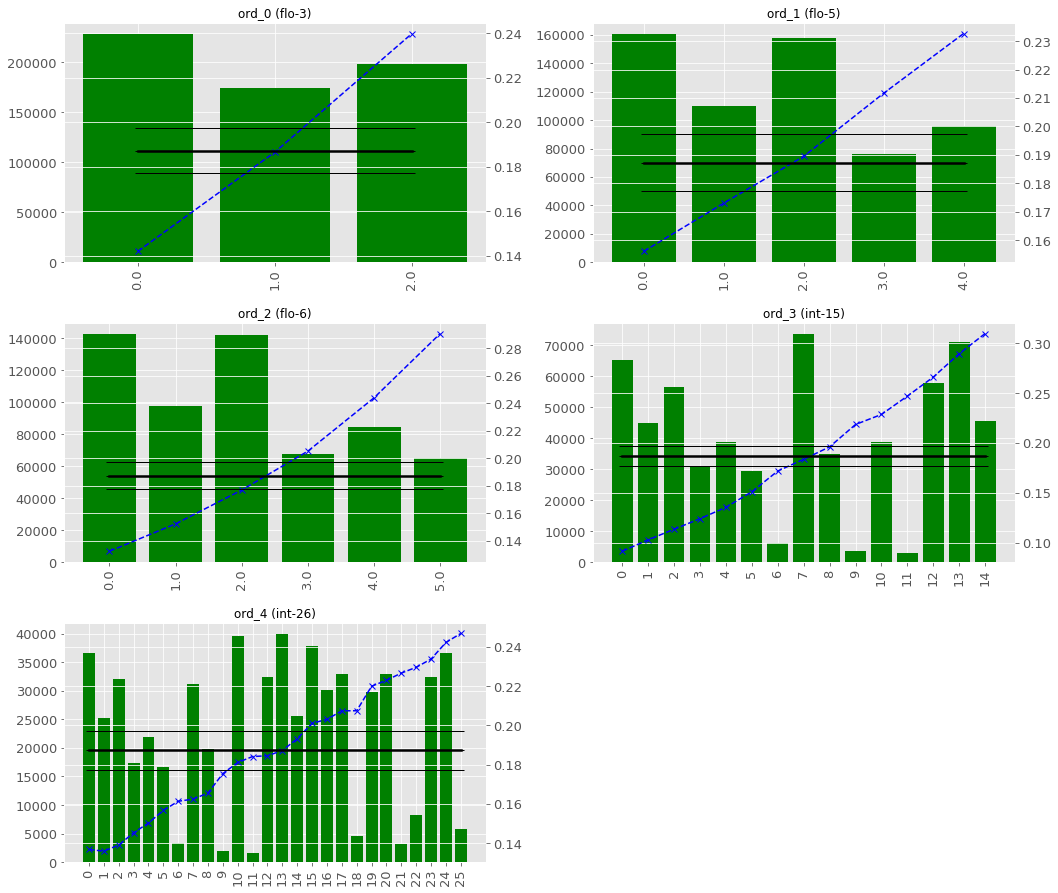

In [175]:
mutils.plot_multiple_categorical(tmp, ordinal_features, col_target="target", top_n=200, n_subplots_per_row=2, save=True)

In [176]:
%%time
drop_cols = ["target", "bin_1_bin_3"]
all_train_cols = [col for col in train.columns if col not in drop_cols]

print(all_train_cols)
imputer = CustomMostFrequentImputer(all_train_cols)
ohe = (pp.OneHotEncoder(categories="auto",dtype="uint8",handle_unknown="ignore"), list(set(all_train_cols)-set(ordinal_features)))
scl = (pp.StandardScaler(copy=False), ordinal_features)
pipe = make_pipeline(imputer, make_column_transformer(ohe, scl), LogisticRegression(**lr_params))

_, b1_chk = cross_val_print(pipe, tmp.drop(drop_cols, axis=1), tmp["target"], cv=fold1, best_score=b1)
_, b2_chk = cross_val_print(pipe, tmp.drop(drop_cols, axis=1), tmp["target"], cv=fold2, best_score=b2)
_, b3_chk = cross_val_print(pipe, tmp.drop(drop_cols, axis=1), tmp["target"], cv=fold3, best_score=b3)

print("Average: {}".format((b1+b2+b3)/3.0))

['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month']


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   31.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   31.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   30.8s finished


↑  CV1 score on valid: 0.7856461 - Previous best valid score: 0.7833945 - Train mean score: 0.801008


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   29.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   32.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   28.4s finished


↑  CV2 score on valid: 0.7856299 - Previous best valid score: 0.7834381 - Train mean score: 0.801103


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   31.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   28.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   31.6s finished


↑  CV3 score on valid: 0.7858564 - Previous best valid score: 0.7836562 - Train mean score: 0.800970
Average: 0.7834962882422755
CPU times: user 3min 23s, sys: 14.9 s, total: 3min 38s
Wall time: 5min 25s


In [177]:
pipe = make_pipeline(imputer, make_column_transformer(ohe), LogisticRegression(**lr_params))
fit_save(pipe, tmp.drop(drop_cols, axis=1), tmp["target"], test, "ORDINAL_ENCODED_MANUALLY_ALL_ONE_HOT")

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   40.6s finished
